In [1]:
%load_ext autoreload
%autoreload 2

# import comet_ml in the top of your file
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="kYVqzmHEUN7WQLo86k2bZs1Z7",
                        project_name="consortium-for-neuropsychiatric-phenomics", workspace="kondratevakate")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kondratevakate/consortium-for-neuropsychiatric-phenomics/14728fbdffbb46c2bb74cc84a96c36e0



In [2]:
import os
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import functools
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import torch
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

In [3]:
!nvidia-smi

Mon Oct  5 18:10:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   30C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   29C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
device = "cuda:1" if torch.cuda.is_available() else 'cpu'
device = torch.device('cuda:1')

print(device)

cuda:1


In [9]:
import sys
sys.path.append('../')

# import utils 
from utils.viz_tools import plot_central_cuts
from data.data import LA5_Siblings_MRI, MriClassification
# from utils import routine

### 1. Defining dataset for structural data

#### We have four options to alayse the structural data:
- BIDS from the original sourse;
- FSL FAST sculltripped;
- FreeSurfer processed;
- fMRIprep processed.

In [10]:
# the first option
os.listdir('/home/datasets/LA5study/BIDS_LA5study/sub-11044/anat')

['sub-11044_T1w.json', 'sub-11044_T1w.nii.gz']

In [11]:
# the third option
os.listdir('/home/datasets/LA5study/LA5_freesurfer/sub-11044/mri');

In [12]:
# LA5_study_general
la5_data = ['/home/datasets/LA5study/fmriprep_LA5study_aroma/fmriprep/']
# la5_data = ['/home/datasets/LA5study/BIDS_LA5study/']
la5_temp_npy_folder_path = '../../LA5study_temp_npy/' # for numpy files
la5_target_path = '../data/LA5study_targets.csv'
#  LA5_study_smri
la5_smri_file_suffix = 'T1w_space-MNI152NLin2009cAsym_preproc.nii'
# la5_smri_file_suffix = '_T1w.nii.gz'
la5_smri_brain_mask_suffix = 'T1w_space-MNI152NLin2009cAsym_brainmask.nii'

In [13]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

LA5 absmax before normalization: 435.0126647949219
Dataset size: 265
Labels distribution: (array([0, 1]), array([140, 125]))

Example:
Image shape: (1, 153, 189, 163)
Target: 1


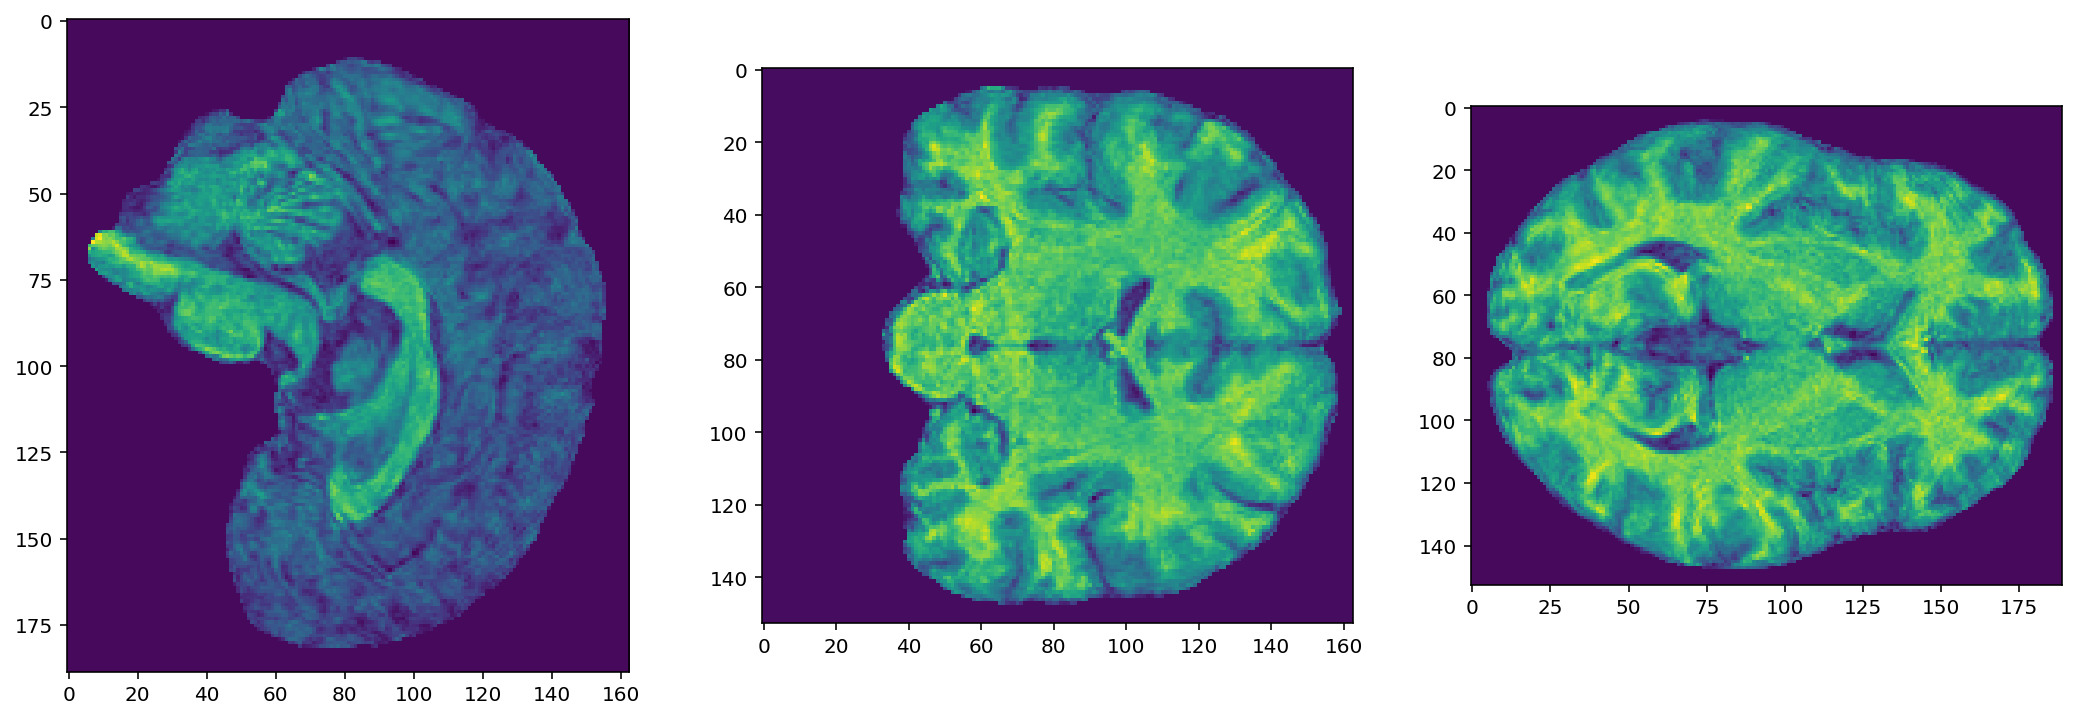

In [14]:
la5_dataset = LA5_Siblings_MRI(
    paths= la5_data,
    target_path= la5_target_path,
    load_online=True,
    mri_type="sMRI",
    mri_file_suffix= la5_smri_file_suffix,
    brain_mask_suffix= la5_smri_brain_mask_suffix,
    coord_min=(20,20,0),
    img_shape=(153, 189, 163),
    problems=['All/Control'],
    temp_storage_path= la5_temp_npy_folder_path
)
la5_absmax = 435.0126647949219 # get_absmax(la5_dataset)
la5_dataset.transform = functools.partial(AbsMaxScale, absmax=la5_absmax)
print("LA5 absmax before normalization: {}".format(la5_absmax))
print("Dataset size: {}".format(len(la5_dataset)))
print("Labels distribution: {}\n".format(np.unique(la5_dataset.labels, return_counts=True)))

print("Example:")
img, target = la5_dataset[0]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
plot_central_cuts(img)

# Model structure

In [25]:
def create_model_opt(model_load_path=None, transfer=False):
    # reproducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    model = models.VoxResNet(num_classes=2, n_filters=32, stride=2, n_blocks=4,
                             input_shape=la5_dataset.img_shape, dropout=0.3, n_fc_units=128,
                             n_flatten_units=23040)
    

    if model_load_path is not None:
        model.load_state_dict(torch.load(model_load_path))  
    if transfer:
        for param in model.parameters():
            param.requires_grad = False
        
        last = torch.nn.Linear(128, 2)
        modules = list(list(model.children())[0].children())[:-1] + [last]
        model = torch.nn.Sequential(torch.nn.Sequential(*modules))
        
        opt = torch.optim.Adam(last.parameters(), lr=3e-5)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, opt

In [31]:
model

VoxResNet(
  (model): Sequential(
    (conv3d_1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (batch_norm_1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_1): ReLU(inplace=True)
    (conv3d_2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (batch_norm_2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_2): ReLU(inplace=True)
    (conv3d_3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (block_1): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affin

## 1. Control vs SCHZ/BIPOLAR/ADHD

#### fmriprep data, VoxResNet, img_size, lr=0.002

In [26]:
from utils.routine import cross_val_score

import utils.models as models

In [27]:
device = torch.device('cuda:1')

Epoch 10 of 10 took 57.584s
  training loss (in-iteration): 	1.000635
  validation loss: 			2.496594
  training roc_auc_score: 			0.65
  validation roc_auc_score: 			0.66


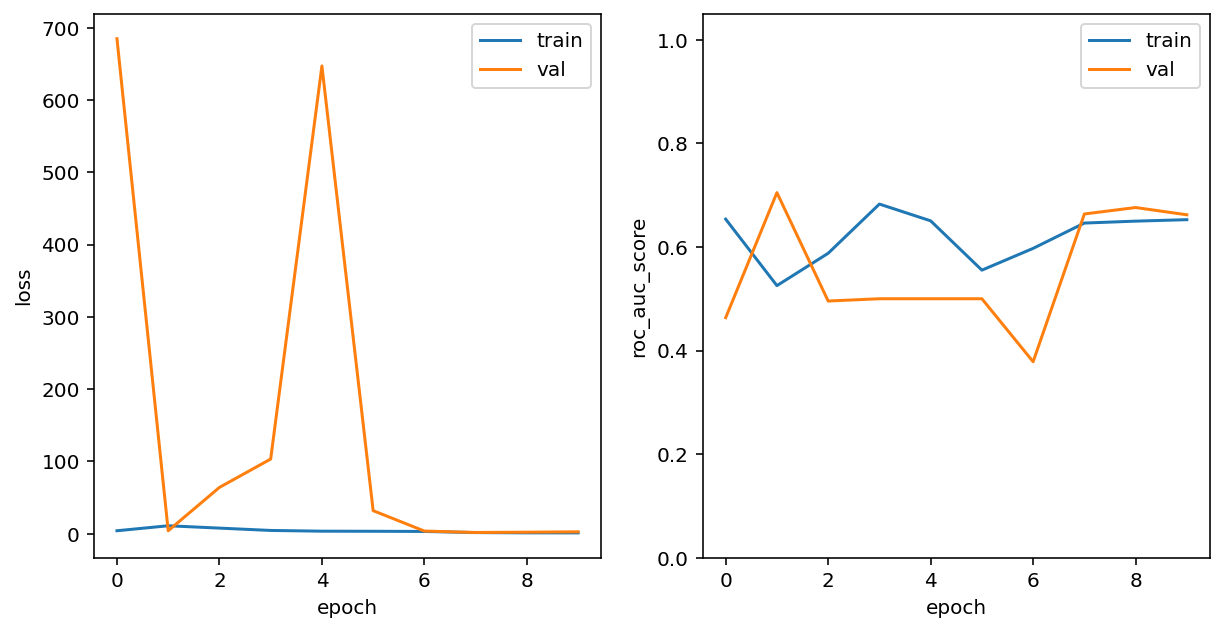

<Figure size 720x360 with 0 Axes>

val roc_auc_scores: [0.6362715298885512, 0.5926501035196686, 0.7049818370524131]
val roc_auc_score mean: 0.6446344901535443
val roc_auc_score std: 0.046238936823945746
CPU times: user 33min, sys: 19min 34s, total: 52min 34s
Wall time: 28min 54s


In [30]:
%%time
torch.cuda.empty_cache()

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = cross_val_score(create_model_opt, la5_dataset, cv, device, metric, batch_size=8)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

In [29]:
#!pip install torchsummary
from torchsummary import summary
model = create_model_opt()[0]
summary(model, (1, 153, 189, 163))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

## 2. Control vs SCHZ/BIPOLAR/ADHD

#### fmriprep data, VoxCNN, img_size

In [55]:
from utils.routine import cross_val_score

import utils.models as models

def create_model_opt(model_load_path=None, transfer=False):
    # reproducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    model = models.CNN(input_shape=(128, 128, 128), n_filters=16, n_blocks=1, stride=1, n_fc_units=128)
    

    if model_load_path is not None:
        model.load_state_dict(torch.load(model_load_path))  
    if transfer:
        for param in model.parameters():
            param.requires_grad = False
        
        last = torch.nn.Linear(128, 2)
        modules = list(list(model.children())[0].children())[:-1] + [last]
        model = torch.nn.Sequential(torch.nn.Sequential(*modules))
        
        opt = torch.optim.Adam(last.parameters(), lr=2e-5)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=2e-5)
    return model, opt

In [56]:
%%time
torch.cuda.empty_cache()
device = torch.device('cuda:1')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = cross_val_score(create_model_opt, la5_dataset, cv, device, metric, batch_size=8)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

RuntimeError: CUDA out of memory. Tried to allocate 2.00 GiB (GPU 1; 15.90 GiB total capacity; 5.26 GiB already allocated; 926.38 MiB free; 5.27 GiB reserved in total by PyTorch)

1. посомотреть метрики, сравнить качество для этой задачи на разных данных, с разными сетками
- поставить комет эксперимент на фиксированном разбиении
- добавить торчио
- для фрисерфера, фмайпрепа
- для сетки cnn и дилейтед
2. посмотреть на конфьюжн матрицу для лучшей?? зочем она нам
3. мб сделать все таки разложение на ICA компоненты и попробовать мать их интерпретировать блядскими пертурбейшонами -___________- ну и заодно заскорить это все на фичах. тип не имеет смысла давать так, а вот блядский ICA -   вполне. для этого оценить внутренню размерность и пересохранить данные в блядскую папку

# val_metrics

In [ ]:
cross_val_score